# Topic modeling using PySpark

[Apache Spark](https://spark.apache.org/) website says that it is a `Lightning-fast unified analytics engine`.

PySpark is a flavour of Spark used for processing and analysing massive volumes of data. We all know how long data processing and cleaning can take as the size of the datasets increase. Enter - PySpark! It decrease the running time and is extremely efficient.

PySpark is the Python API of Spark; which means it can do almost all the things python can. Machine learning(ML) pipelines, exploratory data analysis (at scale), ETLs for data platform, and much more! And all of them in a distributed manner. One of the best parts of pyspark is that if you are already familiar with python, it's really easy to learn.

There is another language called *Scala* used for big data. Scala is usually 10 times faster than Python. But, since that requires learning another language, let's stick to PySpark.

## SparkNLP module
SparkNLP is developed and maintained by
[John Snow Labs](https://nlp.johnsnowlabs.com).
It is an open-source text processing module
built on top of Apache Spark and spark ML library.
It supports Python, Scala and Java.

## PySpark ML module
This contains dataframe-based ML Pipeline APIs
which lets users quickly assemble and configure
ML solutions. It is fast and uses distributed computing.
To learn more about PySpark ML package, refer
[here](https://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html).


## Install pyspark library

In [35]:
!pip install -q pyspark==3.3.0 spark-nlp==5.0.2

In [36]:
import sparknlp
spark = sparknlp.start()

print("Spark NLP version:", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version: 5.0.2
Apache Spark version: 3.3.0


## Import packages

In [37]:
# pyspark packages
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession

# pyspark ml packages
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer, IDF

# sparknlp packages
from sparknlp.base import *
from sparknlp.annotator import *

# other packages
import re
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

# visualization packages
from ipywidgets import interact
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data
Read data from local directory

In [38]:
pandasDF = pd.read_csv('dataset.csv')
pandasDF.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [39]:
pandasDF.shape

(20972, 9)

### Convert pandas dataframe into spark dataframe

Note: Usually the dataset is read from a database or a data lake storage on cloud.

In [40]:
# building a spark session is required
# call this spark session - pandas to spark
sparkS = SparkSession.builder.appName("pandas to spark").getOrCreate()

In [41]:
sparkDF = sparkS.createDataFrame(pandasDF)

In [42]:
sparkDF.show(5)

+---+--------------------+--------------------+----------------+-------+-----------+----------+--------------------+--------------------+
| ID|               TITLE|            ABSTRACT|Computer Science|Physics|Mathematics|Statistics|Quantitative Biology|Quantitative Finance|
+---+--------------------+--------------------+----------------+-------+-----------+----------+--------------------+--------------------+
|  1|Reconstructing Su...|  Predictive mode...|               1|      0|          0|         0|                   0|                   0|
|  2|Rotation Invarian...|  Rotation invari...|               1|      0|          0|         0|                   0|                   0|
|  3|Spherical polyhar...|  We introduce an...|               0|      0|          1|         0|                   0|                   0|
|  4|A finite element ...|  The stochastic ...|               0|      0|          1|         0|                   0|                   0|
|  5|Comparative study...|  Fourie

## Processing text columns

### User-defined functions required

The following functions are defined in this notebook to process the text columns in the dataframe and obtain the topics out of the data using `sparknlp` and `pyspark.ml` packages.
- `clean_sentence` - removes punctuations, special characters, additional spaces and any words with length < 3
- `getTopics` - obtains the terms from each of the topics from `sparkLDA` model

In [43]:
@udf("string")
def clean_sentence(sentence):

  '''function to clean up the sentences
  this removes punctuations, special characters,
  numbers, additional spaces in between
  words and remove any words whose length < 3.'''

  #replace non-alpha characters with spaces
  sentence = re.sub(r"[^a-z A-Z]", " ", sentence)

  #replace any extra spaces
  sentence = re.sub(r"/s+", "", sentence)

  #only retain words of length >= 3
  sentence = " ".join([ele for ele in sentence.split() if len(ele) >= 3])

  return sentence

In [44]:
@udf(ArrayType(StringType()))
def getTopics(token_list):

  '''funtion to get the terms from each of the
  topics from sparkLDA model'''

  tlist = [vocab[token_id] for token_id in token_list]
  return tlist

### Combine text columns
The two columns containing text are combined into one and create a new column `Text` which will be the inpiut for all the text processing, text clean-up and eventually the topic modeling. Retain only the text columns as the rest are not required for topic modeling

In [45]:
sparkDF = sparkDF.withColumn("Content", concat(col("Title"), lit(" "), col("Abstract")))
sparkDF = sparkDF.select("Title", "Abstract", "Content")
sparkDF.show(5)

+--------------------+--------------------+--------------------+
|               Title|            Abstract|             Content|
+--------------------+--------------------+--------------------+
|Reconstructing Su...|  Predictive mode...|Reconstructing Su...|
|Rotation Invarian...|  Rotation invari...|Rotation Invarian...|
|Spherical polyhar...|  We introduce an...|Spherical polyhar...|
|A finite element ...|  The stochastic ...|A finite element ...|
|Comparative study...|  Fourier-transfo...|Comparative study...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [46]:
# apply the above function to clean up text and create a new column
# the regexp_replace function applied below cleans up strings
# which have more than 2 same letters consecutively in a word

sparkDF = sparkDF.withColumn("Text", clean_sentence(regexp_replace(col("Content"), \
                                                            r"(\w)\1{2}", "")))

In [47]:
sparkDF

DataFrame[Title: string, Abstract: string, Content: string, Text: string]

### Define spark-nlp pipelines
Define the following spark pipelines before topic modeling to
- tokenize
- lemmatize
- remove stopwords
- part of speech tagging
- retain only nouns, verbs and adjectives

In [48]:
documentAssembler = DocumentAssembler() \
                      .setInputCol("Text") \
                      .setOutputCol("document")

sentence = SentenceDetector() \
            .setInputCols("document") \
            .setOutputCol("sentence")

tokenizer = Tokenizer() \
              .setInputCols(["sentence"]) \
              .setOutputCol("token")

POSTag = PerceptronModel.pretrained() \
          .setInputCols("document", "token") \
          .setOutputCol("pos")

chunker = Chunker() \
            .setInputCols("sentence", "pos") \
            .setOutputCol("chunk") \
            .setRegexParsers(["<NN>", "<NNS>", "<NNP>", "<VB>", "<JJ>", "<ADJ>"])

lemmatizer = LemmatizerModel.pretrained() \
              .setInputCols(["token"]) \
              .setOutputCol("lemmatized")

stopwordsCleaner = StopWordsCleaner() \
                    .setStopWords(StopWordsRemover \
                            .loadDefaultStopWords("english")) \
                    .setInputCols(["lemmatized"]) \
                    .setOutputCol("unigram")

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [49]:
pipeline1 = Pipeline().setStages(
              [documentAssembler,
               sentence,
               tokenizer,
               POSTag,
               chunker,
               lemmatizer,
               stopwordsCleaner
               ])

In [50]:
df = pipeline1.fit(sparkDF).transform(sparkDF)

In [51]:
# df.show(5)

In [52]:
finalDF = df.select("Text", col("unigram.result").alias("unigrams")) \
                      .withColumn("unigrams", clean_sentence(
                          regexp_replace(clean_sentence(
                              concat_ws(", ", array_distinct(
                                  split(regexp_replace(
                                          concat_ws(", ", col("unigrams")),
                                        "[^A-Za-z0-9]", " "),
                                      " "))
                              )), r"\s*[A-Z]\w*\s*", " "
                          ))
                      )

In [53]:
# finalDF.show(5)

In [54]:
# split the unigrams into separate terms
# filter to keep only the non-null entries

finalDF = finalDF.filter(col("unigrams").isNotNull()) \
        .withColumn("terms", split(col("unigrams"), " ")) \
        .select("Text", "terms")

In [55]:
finalDF.show(5)

+--------------------+--------------------+
|                Text|               terms|
+--------------------+--------------------+
|Reconstructing Su...|[model, allow, su...|
|Rotation Invarian...|[invariance, tran...|
|Spherical polyhar...|[polyharmonics, k...|
|finite element ap...|[finite, element,...|
|Comparative study...|[study, decomposi...|
+--------------------+--------------------+
only showing top 5 rows



## Topic modeling
Use the pyspark ml libraries to obtain the topics and the terms along with their proabilities.

In [56]:
tfzer = CountVectorizer(inputCol = "terms", outputCol = "tfFeatures")
tfModel = tfzer.fit(finalDF)
tfResult = tfModel.transform(finalDF)

In [57]:
idfzer = IDF(inputCol = "tfFeatures", outputCol = "tfidfFeatures")
idfModel = idfzer.fit(tfResult)
tfidfResult = idfModel.transform(tfResult)

In [58]:
lda = LDA(k=3, maxIter = 5, featuresCol = "tfidfFeatures")
ldaModel = lda.fit(tfidfResult)

In [59]:
ldaModel.describeTopics(10).show(5)

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[6, 10, 3, 7, 2, ...|[0.00190135171415...|
|    1|[139, 1, 53, 25, ...|[0.00172494557790...|
|    2|[18, 15, 16, 14, ...|[0.00144975348071...|
+-----+--------------------+--------------------+



In [60]:
vocab = tfModel.vocabulary

topics = ldaModel.describeTopics(10).withColumn("TopicTerms", \
                                                getTopics(col("termIndices"))) \
                                    .withColumnRenamed("termWeights", "TermProb") \
                                    .select("Topic", "TopicTerms", "TermProb")

In [61]:
topics.show()

+-----+--------------------+--------------------+
|Topic|          TopicTerms|            TermProb|
+-----+--------------------+--------------------+
|    0|[method, data, mo...|[0.00190135171415...|
|    1|[group, show, pro...|[0.00172494557790...|
|    2|[well, approach, ...|[0.00144975348071...|
+-----+--------------------+--------------------+



In [62]:
topicsDF = topics.withColumn("ID", monotonically_increasing_id()) \
                  .withColumn("new", arrays_zip("TopicTerms", "TermProb")) \
                  .withColumn("new", explode("new")) \
                  .select("ID", "Topic", col("new.TopicTerms").alias("TopicTerms"), \
                          col("new.TermProb").alias("TermProb"))

In [63]:
topicsDF.show(10)

+---+-----+----------+--------------------+
| ID|Topic|TopicTerms|            TermProb|
+---+-----+----------+--------------------+
|  0|    0|    method|0.001901351714155...|
|  0|    0|      data|0.001819539327412...|
|  0|    0|     model|0.001784254621530...|
|  0|    0|   propose|0.001733242596248...|
|  0|    0|    result|0.001716011871714...|
|  0|    0|      time|0.001712096837753...|
|  0|    0|       use|0.001710695474587...|
|  0|    0|      show|0.001700484774013...|
|  0|    0|   problem|0.001659324202298...|
|  0|    0|   provide|0.001657725063158177|
+---+-----+----------+--------------------+
only showing top 10 rows



## Visualization

This can be also done using Tableau or Power BI or any other dashboarding services.

The following is a quick way to visualize the results.

Note: It is easier to do plots using pandas dataframe, dso will convert the above dataframes - `topics` and `topicsDF` into pandas.

In [64]:
# convert spark dataframe into pandas

topicsPD = topics.toPandas()
topicsDFpd = topicsDF.toPandas()

In [65]:
topicList = topicsPD.Topic.tolist()

In [66]:
topicFilter = widgets.RadioButtons(
    options=topicList,
    value=topicList[0],
    description='Topic:',
    disabled=False,
)

In [67]:
def plot_topics(topicn):
  print("terms in Topic: ", topicn, "\n", \
        topicsPD.loc[topicn, "TopicTerms"])
  fig, ax = plt.subplots()
  p = ax.barh(topicsPD.loc[topicn, "TopicTerms"], \
            topicsPD.loc[topicn, "TermProb"])
  ax.set_axis_off

interactive(children=(RadioButtons(description='Topic:', options=(0, 1, 2), value=0), Output()), _dom_classes=…

<function __main__.plot_topics(topicn)>

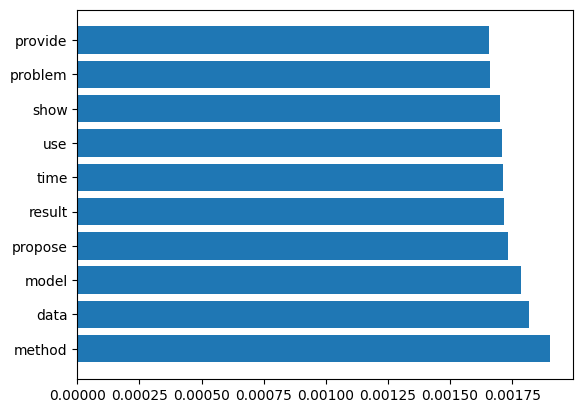

In [68]:
interact(plot_topics, topicn=topicFilter)